In [1]:
library(loadeR)
library(transformeR)
library(visualizeR)
library(climate4R.UDG)
library(dplyr)
library(climate4R.value)
library(VALUE)

Warning message:
"package 'loadeR' was built under R version 3.6.3"

Loading required package: rJava
Warning message:
"package 'rJava' was built under R version 3.6.3"Loading required package: loadeR.java
Warning message:
"package 'loadeR.java' was built under R version 3.6.3"Java version 21x amd64 by Azul Systems, Inc. detected
NetCDF Java Library v4.6.0-SNAPSHOT (23 Apr 2015) loaded and ready
Loading required package: climate4R.UDG
Warning message:
"package 'climate4R.UDG' was built under R version 3.6.3"climate4R.UDG version 0.2.6 (2023-06-26) is loaded
Please use 'citation("climate4R.UDG")' to cite this package.
loadeR version 1.8.1 (2023-06-22) is loaded
Please use 'citation("loadeR")' to cite this package.
Warning message:
"package 'transformeR' was built under R version 3.6.3"


    _______   ____  ___________________  __  ________ 
   / ___/ /  / /  |/  / __  /_  __/ __/ / / / / __  / 
  / /  / /  / / /|_/ / /_/ / / / / __/ / /_/ / /_/_/  
 / /__/ /__/ / /  / / __  / / / / /__ /___  / / \ \ 
 \___/____/_/_/  /_/_/ /_/ /_/  \___/    /_/\/   \_\ 
 
      github.com/SantanderMetGroup/climate4R



transformeR version 2.2.2 (2023-10-26) is loaded
Please see 'citation("transformeR")' to cite this package.
Warning message:
"package 'visualizeR' was built under R version 3.6.3"visualizeR version 1.6.4 (2023-10-26) is loaded
Please see 'citation("visualizeR")' to cite this package.
Warning message:
"package 'dplyr' was built under R version 3.6.3"
Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

Warning message:
"package 'climate4R.value' was built under R version 3.6.3"Loading required package: VALUE
Warning message:
"package 'VALUE' was built under R version 3.6.3"---------------------------------------------- 
| VALUE version 2.2.4 (2023-06-22) is loaded |
|         http://www.value-cost.eu           |
----------------------------------------------


In [4]:
# Leer el archivo CSV
df <- read.csv("https://data.meteo.unican.es/inventory.csv") # inventario con muchos datasets
# Filtrar los enlaces que necesitas
sub <- subset(df, product == 'AEMET-5KM-regular')
obs.url <- as.character(sub$location)
# Ejecutar dataInventory con los enlaces filtrados
di <- dataInventory(obs.url)


[2024-04-10 11:29:51] Doing inventory ...
[2024-04-10 11:29:51] Opening dataset...
[2024-04-10 11:29:54] The dataset was successfuly opened
[2024-04-10 11:29:55] Retrieving info for 'pr' (2 vars remaining)
[2024-04-10 11:29:55] Retrieving info for 'tasmax' (1 vars remaining)
[2024-04-10 11:29:56] Retrieving info for 'tasmin' (0 vars remaining)
[2024-04-10 11:29:56] Done.


In [ ]:
pr <- loadGridData(obs.url, var = "pr")
tmax <- loadGridData(obs.url, var = "tasmax")

In [4]:
pr <- upscaleGrid(pr, times = 2, aggr.fun = list(FUN = mean, na.rm = TRUE))
tmax <- upscaleGrid(tmax, times = 2, aggr.fun = list(FUN = mean, na.rm = TRUE))

: 

## Quantile

### Parte Húmeda

In [13]:
pr_h <- pr

In [16]:
# Parte Humeda Precipitacion
dimension <- dim(pr_h$Data)
for (a in 1:dimension[3]) {
  for (i in 1:dimension[4]) {
    for (j in 1:dimension[5]) {
      if (!is.na(pr_h$Data[1,1,a,i,j])) { # Check for missing values
          if (pr_h$Data[1,1,a,i,j] <= 0.1) {
              pr_h$Data[1,1,a,i,j] <- NaN
            }
          }
        }
      }
  }

In [5]:
seasons <- list(Winter = c(12, 1, 2), Spring = c(3, 4, 5), Summer = c(6, 7, 8), Autumn = c(9, 10, 11))
# Function to apply climatology to a dataset for a specific season and quantile level
ref_quantile <- function(data, quantile) {
    # data: a grid with the data
    # quantile: number of the quantile to calculate
  results <- list()
  for (season_name in names(seasons)) {
    season_month <- seasons[[season_name]]
    season_data <- subsetGrid(data, season = season_month)
    quantile_result <- climatology(season_data, clim.fun = list(FUN = "quantile", probs = quantile, na.rm = TRUE))
    results[[season_name]] <- quantile_result
  }
  return(results)
}

In [6]:
pr_h <- ref_quantile(pr_h, 0.10)
tmax_h <- ref_quantile(tmax, 0.90)

NOTE: Some data will be lost on year-crossing season subset (see the 'Time slicing' section of subsetGrid documentation for more details)
[2024-04-05 13:26:01] - Computing climatology...
[2024-04-05 13:26:02] - Done.
[2024-04-05 13:26:02] - Computing climatology...
[2024-04-05 13:26:03] - Done.
[2024-04-05 13:26:03] - Computing climatology...
[2024-04-05 13:26:04] - Done.
[2024-04-05 13:26:05] - Computing climatology...
[2024-04-05 13:26:06] - Done.


## Subset

In [8]:
# Define the seasons and years to process
seasons <- list(Winter = c(12, 1, 2), Spring = c(3, 4, 5), Summer = c(6, 7, 8), Autumn = c(9, 10, 11))
years <- seq(1951, 2022, by = 1)

processed_data <- function(data){
    # Function to obtain the data by season and year
    # data: a grid with the data
    
    new_data <- lapply(as.character(years), function(y) {
        new_data_year <- list()
        
        for (season_name in names(seasons)) {
            season_months <- seasons[[season_name]]
            
            if (season_name == "Winter") {
                # Winter, include December of the previous year
                if (as.numeric(y) != min(years)) {
                    previous_dec <- subsetGrid(data, year = as.numeric(y) - 1, season = c(12))
                    current_en_feb <- subsetGrid(data, year = as.numeric(y), season = c(1, 2))
                    winter_data <- bindGrid(previous_dec, current_en_feb, dimension = "time")
                    new_data_year[[season_name]] <- winter_data
                } else {
                    current_en_feb <- subsetGrid(data, year = as.numeric(y), season = c(1, 2))
                    new_data_year[[season_name]] <- current_en_feb
                }
            } else {
                # Rest of the seasons
                data_season_year <- subsetGrid(data, year = as.numeric(y), season = season_months)
                new_data_year[[season_name]] <- data_season_year
            }
        }
        
        return(new_data_year)
    })
    
    names(new_data) <- as.character(years)
    
    return(new_data)
}

In [9]:
pr <- processed_data(pr)
tmax <- processed_data(tmax)

## Binarization

In [4]:
binarization <- function(grid_data, quantile, variable) {
# Iterate over the years in the data grid
  for (year in names(grid_data)) {
    # Iterate over the seasons of each year
    for (season in names(grid_data[[year]])) {
      # Get current station data
      season_data <- grid_data[[year]][[season]]
      season_quantile <- quantile[[season]]
      
      # Dimension of the data
      dims <- dim(season_data$Data)
      # Iterate over dimensions and convert to binary
      for (a in 1:dims[1]) {
        for (i in 1:dims[2]) {
          for (j in 1:dims[3]) {
            if (!is.na(season_data$Data[a, i, j]) && !is.na(season_quantile$Data[1, i, j])) {
              # If it is precipitation
              if(variable == "pr"){
                if (season_data$Data[a, i, j] < season_quantile$Data[1, i, j]) {
                  season_data$Data[a, i, j] <- 1
                } else {
                  season_data$Data[a, i, j] <- 0
                }
              # If it is tmax
              } else if (variable == "tmax"){
                if (season_data$Data[a, i, j] > season_quantile$Data[1, i, j]) {
                  season_data$Data[a, i, j] <- 1
                } else {
                  season_data$Data[a, i, j] <- 0
                }
              }
            }
          }
        }
      }
      
      # Actualizar el grid de datos con la estación binarizada
      grid_data[[year]][[season]] <- season_data
    }
  }
  
  # Devolver el grid de datos binarizado
  return(grid_data)
}

In [5]:
pr_bin <- binarization(pr, pr_h, "pr")
tmax_bin <- binarization(tmax, tmax_h, "tmax")

## CE

In [6]:
# Create a function that iter over the years and seasons of two datagrids and execute the function gridArithmetics
compound_event <- function(grid1, grid2) {
  grid3 <- grid1
  # Iterate over the years in the grid
  for (year in names(grid1)) {
    # Iterate over the seasons in each year
    for (season in names(grid1[[year]])) {
      # Get the data of the current season
      season_data1 <- grid1[[year]][[season]]
      season_data2 <- grid2[[year]][[season]]
      # Apply the function to the data
      event_compount <- gridArithmetics(season_data1, season_data2, operator = "*")
      # Update the data grid with the result
      grid3[[year]][[season]] <- event_compount
    }
  }
  # Return the updated grid
  return(grid3)
}

In [7]:
CE <- compound_event(pr_bin, tmax_bin)

## SumCE

In [ ]:
capa_tierra <- tmax_h$Spring
capa_tierra$Data[!is.na(capa_tierra$Data)] <- 1

In [16]:
# Create a function that iter over the years and seasons of one data grid and execute the function climatology to summarize the data
sum_events <- function(grid) {
  grid1 <- grid
  # Iterate over the years in the grid
  for (year in names(grid)) {
    # Iterate over the seasons in each year
    for (season in names(grid[[year]])) {
      # Get the data of the current season
      season_data1 <- grid[[year]][[season]]
      # Apply the function to the data
      sum_events <- climatology(season_data1, clim.fun = list(FUN = "sum", na.rm = TRUE))
      sum_events <- gridArithmetics(sum_events, capa_tierra, operator = "*")
      # Update the data grid with the result
      grid1[[year]][[season]] <- sum_events
    }
  }
  # Return the updated grid
  return(grid1)
}

In [17]:
sumCE <- sum_events(CE)

[2024-04-08 10:54:55] - Computing climatology...
[2024-04-08 10:54:55] - Done.
[2024-04-08 10:54:55] - Computing climatology...


[2024-04-08 10:54:55] - Done.
[2024-04-08 10:54:55] - Computing climatology...
[2024-04-08 10:54:55] - Done.
[2024-04-08 10:54:55] - Computing climatology...
[2024-04-08 10:54:55] - Done.
[2024-04-08 10:54:56] - Computing climatology...
[2024-04-08 10:54:56] - Done.
[2024-04-08 10:54:56] - Computing climatology...
[2024-04-08 10:54:56] - Done.
[2024-04-08 10:54:56] - Computing climatology...
[2024-04-08 10:54:56] - Done.
[2024-04-08 10:54:56] - Computing climatology...
[2024-04-08 10:54:56] - Done.
[2024-04-08 10:54:56] - Computing climatology...
[2024-04-08 10:54:56] - Done.
[2024-04-08 10:54:56] - Computing climatology...
[2024-04-08 10:54:56] - Done.
[2024-04-08 10:54:56] - Computing climatology...
[2024-04-08 10:54:56] - Done.
[2024-04-08 10:54:56] - Computing climatology...
[2024-04-08 10:54:56] - Done.
[2024-04-08 10:54:56] - Computing climatology...
[2024-04-08 10:54:56] - Done.
[2024-04-08 10:54:56] - Computing climatology...
[2024-04-08 10:54:56] - Done.
[2024-04-08 10:54:56] 

## Group

In [18]:
# Función para realizar bindGrid de una estación específica para varios años
bindGridEstaciones <- function(datos, estacion) {
  # Extraemos los años disponibles en los datos
  years <- names(datos)
  
  # Creamos una lista para almacenar los grids de cada año
  lista_grids <- list()
  
  # Iteramos sobre los años
  for (year in years) {
    # Obtenemos el grid para la estación especificada
    grid <- datos[[year]][[estacion]]
    # Lo añadimos a la lista
    lista_grids[[year]] <- grid
  }
  
  # Realizamos el bindGrid con todos los grids de la lista
  resultado <- bindGrid(lista_grids, dimension = "time", skip.temporal.check = TRUE)
  return(resultado)
}

In [19]:
# Crear un vector con los nombres de las estaciones
estaciones <- c("Winter", "Spring", "Summer", "Autumn")

# Crear una lista para almacenar los resultados
dataPeriod <- list()

# Iterar sobre las estaciones
for (estacion in estaciones) {
  # Obtener los datos para la estación actual
  datos_estacion <- bindGridEstaciones(sumCE, estacion = estacion)
  datos_estacion <- climatology(datos_estacion, clim.fun = list(FUN = "sum", na.rm = TRUE))
  datos_estacion <- gridArithmetics(datos_estacion, capa_tierra, operator = "*")
  
  # Almacenar los resultados en la lista
  dataPeriod[[estacion]] <- datos_estacion
}

[2024-04-08 10:58:00] - Computing climatology...
[2024-04-08 10:58:00] - Done.
[2024-04-08 10:58:00] - Computing climatology...
[2024-04-08 10:58:00] - Done.
[2024-04-08 10:58:01] - Computing climatology...
[2024-04-08 10:58:01] - Done.
[2024-04-08 10:58:01] - Computing climatology...
[2024-04-08 10:58:01] - Done.


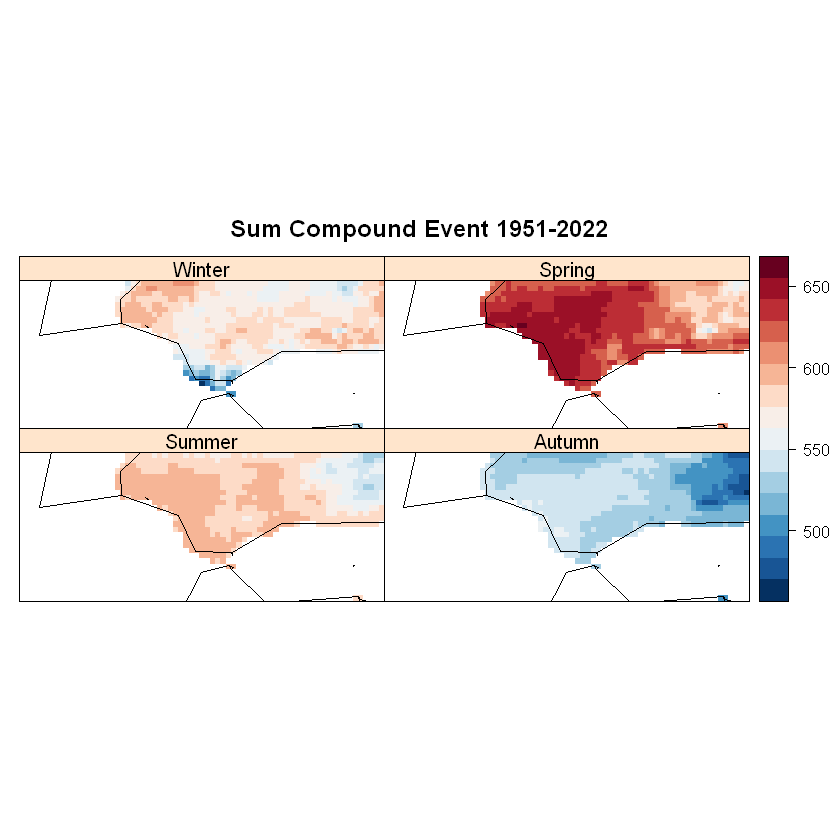

In [20]:
fullPeriod <- bindGrid(dataPeriod$Winter , dataPeriod$Spring, dataPeriod$Summer, dataPeriod$Autumn, dimension = "member", skip.temporal.check = TRUE)
spatialPlot(fullPeriod, color.theme = "RdBu", rev.colors = TRUE, as.table = TRUE, names.attr = c("Winter", "Spring", "Summer", "Autumn"), backdrop.theme = "countries", main = "Sum Compound Event 1951-2022")

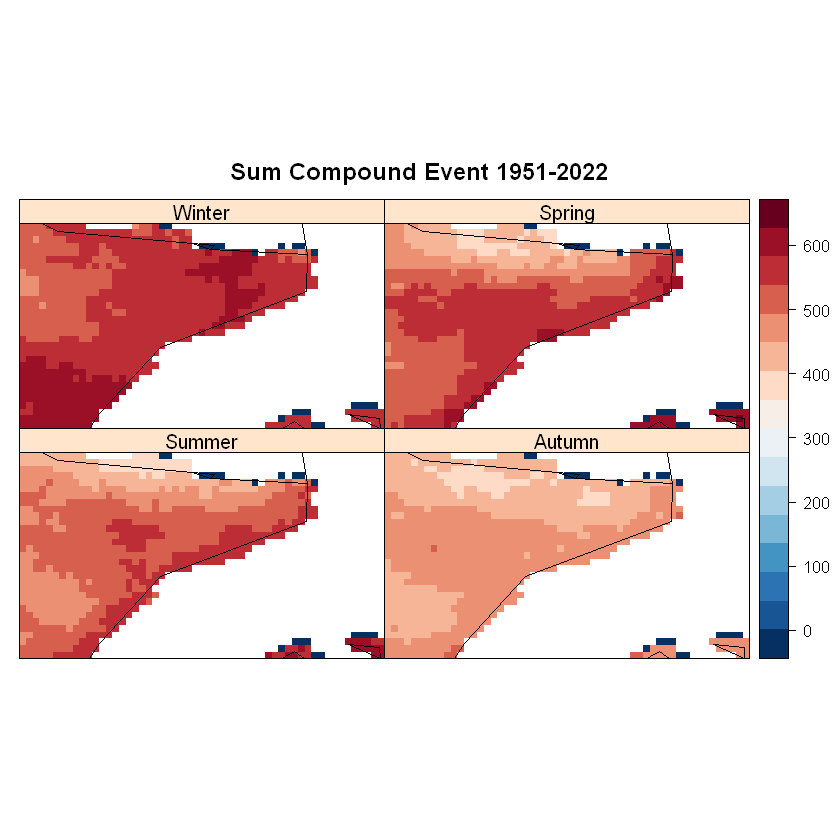

In [25]:
fullPeriod <- bindGrid(dataPeriod$Winter , dataPeriod$Spring, dataPeriod$Summer, dataPeriod$Autumn, dimension = "member", skip.temporal.check = TRUE)
spatialPlot(fullPeriod, color.theme = "RdBu", rev.colors = TRUE, as.table = TRUE, names.attr = c("Winter", "Spring", "Summer", "Autumn"), backdrop.theme = "countries", main = "Sum Compound Event 1951-2022")

## Trend

In [21]:
winter <- bindGridEstaciones(sumCE, "Winter")
spring <- bindGridEstaciones(sumCE, "Spring")
summer <- bindGridEstaciones(sumCE, "Summer")
autumn <- bindGridEstaciones(sumCE, "Autumn")

[2024-04-08 10:59:07] Computing member 1 out of 1


[2024-04-08 10:59:25] Done.
[2024-04-08 10:59:25] Computing member 1 out of 1
[2024-04-08 10:59:46] Done.
[2024-04-08 10:59:46] - Computing climatology...
[2024-04-08 10:59:46] - Done.


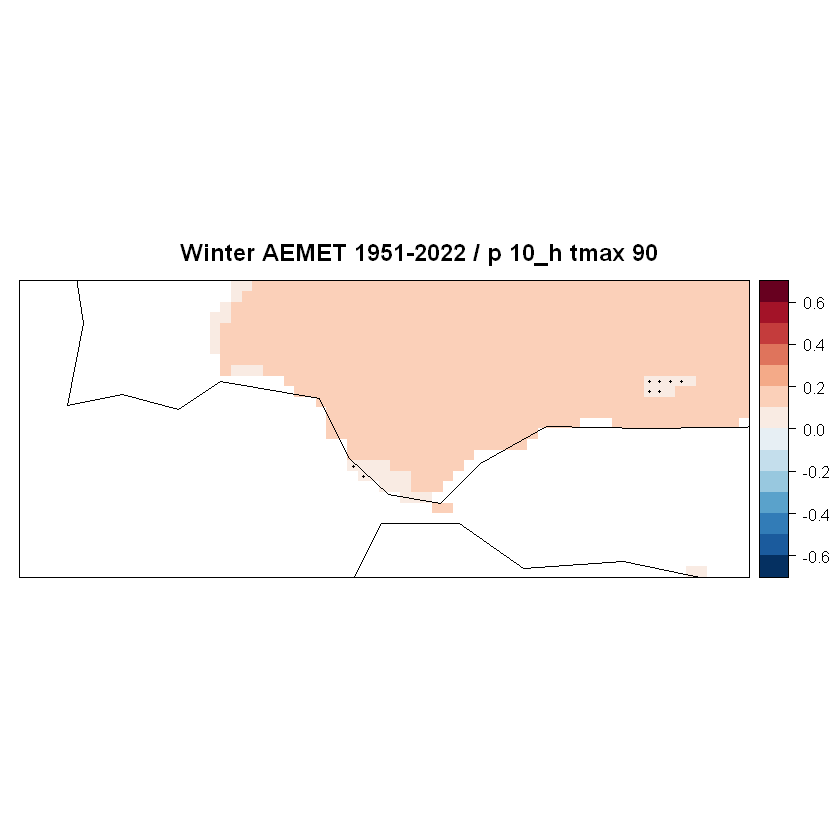

In [22]:
trend.winter <- valueIndex(winter, index.code = "Trend", return.NApercentage = FALSE)# La pendiente
sig.winter <- valueIndex(winter, index.code = "TrendSig", return.NApercentage = FALSE) # La significancia (1 o 0)
# Si significancia es 0 entonces la pendiente no es significativa = NA
clim.w = climatology(sig.winter)
points.winter <- visualizeR::map.stippling(clim.w, thereshold = 0.05, condition = "LT", pch = 19, cex = 0.25, col = "black")
# Representación
spatialPlot(trend.winter, backdrop.theme = "coastline", color.theme = "RdBu", at = seq(-0.7, 0.7, by = 0.1), set.max = 0.7, set.min = -0.7, rev.colors = TRUE, main = "Winter AEMET 1951-2022 / p 10_h tmax 90", sp.layout = list(points.winter))

[2024-04-08 10:59:47] Computing member 1 out of 1


[2024-04-08 11:00:07] Done.
[2024-04-08 11:00:07] Computing member 1 out of 1
[2024-04-08 11:00:24] Done.
[2024-04-08 11:00:24] - Computing climatology...
[2024-04-08 11:00:24] - Done.


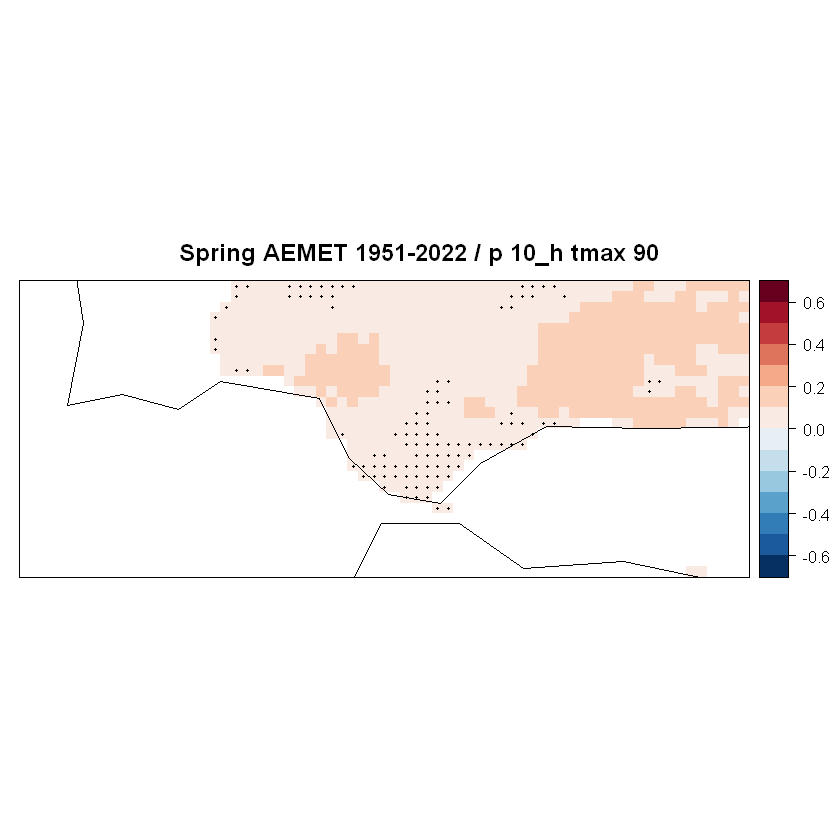

In [23]:
trend.spring <- valueIndex(spring, index.code = "Trend", return.NApercentage = FALSE)# La pendiente
sig.spring <- valueIndex(spring, index.code = "TrendSig", return.NApercentage = FALSE) # La significancia (1 o 0)
# Si significancia es 0 entonces la pendiente no es significativa = NA
clim.spring = climatology(sig.spring)
points.spring <- visualizeR::map.stippling(clim.spring, thereshold = 0.05, condition = "LT", pch = 19, cex = 0.25, col = "black")
# Representación
spatialPlot(trend.spring, backdrop.theme = "coastline", color.theme = "RdBu", at = seq(-0.7, 0.7, by = 0.1), set.max = 0.7, set.min = -0.7, rev.colors = TRUE, main = "Spring AEMET 1951-2022 / p 10_h tmax 90", sp.layout = list(points.spring))

[2024-04-08 11:00:25] Computing member 1 out of 1


[2024-04-08 11:00:42] Done.
[2024-04-08 11:00:42] Computing member 1 out of 1
[2024-04-08 11:01:00] Done.
[2024-04-08 11:01:00] - Computing climatology...
[2024-04-08 11:01:00] - Done.


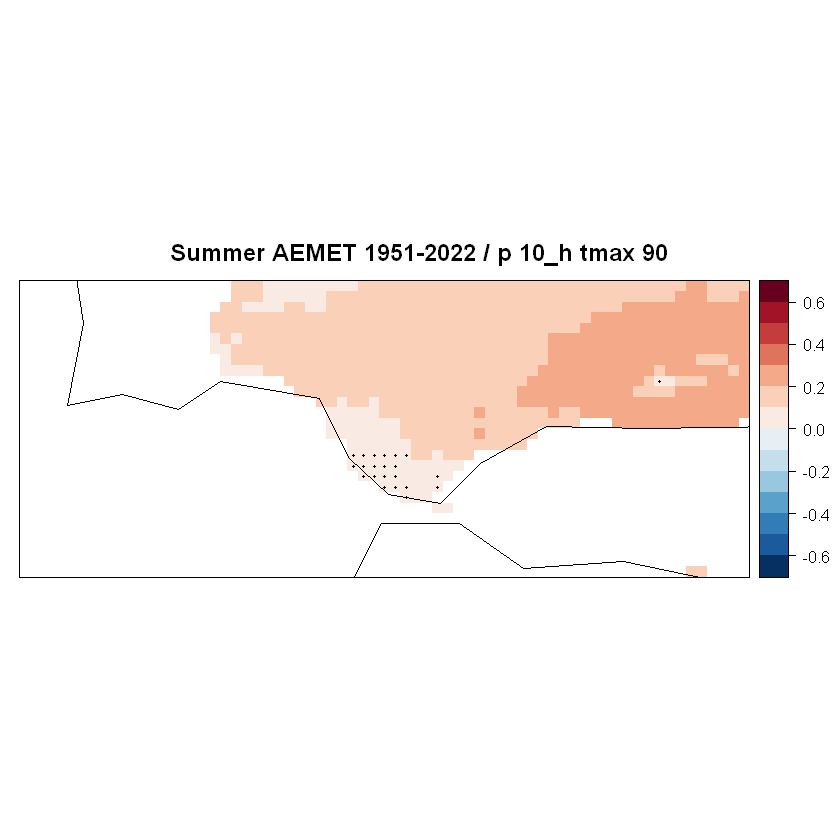

In [24]:
trend.summer <- valueIndex(summer, index.code = "Trend", return.NApercentage = FALSE)# La pendiente
sig.summer <- valueIndex(summer, index.code = "TrendSig", return.NApercentage = FALSE) # La significancia (1 o 0)
# Si significancia es 0 entonces la pendiente no es significativa = NA
clim.summer = climatology(sig.summer)
points.summer <- visualizeR::map.stippling(clim.summer, thereshold = 0.05, condition = "LT", pch = 19, cex = 0.25, col = "black")
# Representación
spatialPlot(trend.summer, backdrop.theme = "coastline", color.theme = "RdBu", at = seq(-0.7, 0.7, by = 0.1), set.max = 0.7, set.min = -0.7, rev.colors = TRUE, main = "Summer AEMET 1951-2022 / p 10_h tmax 90", sp.layout = list(points.summer))

[2024-04-08 11:01:01] Computing member 1 out of 1


[2024-04-08 11:01:17] Done.
[2024-04-08 11:01:17] Computing member 1 out of 1
[2024-04-08 11:01:34] Done.
[2024-04-08 11:01:34] - Computing climatology...
[2024-04-08 11:01:34] - Done.


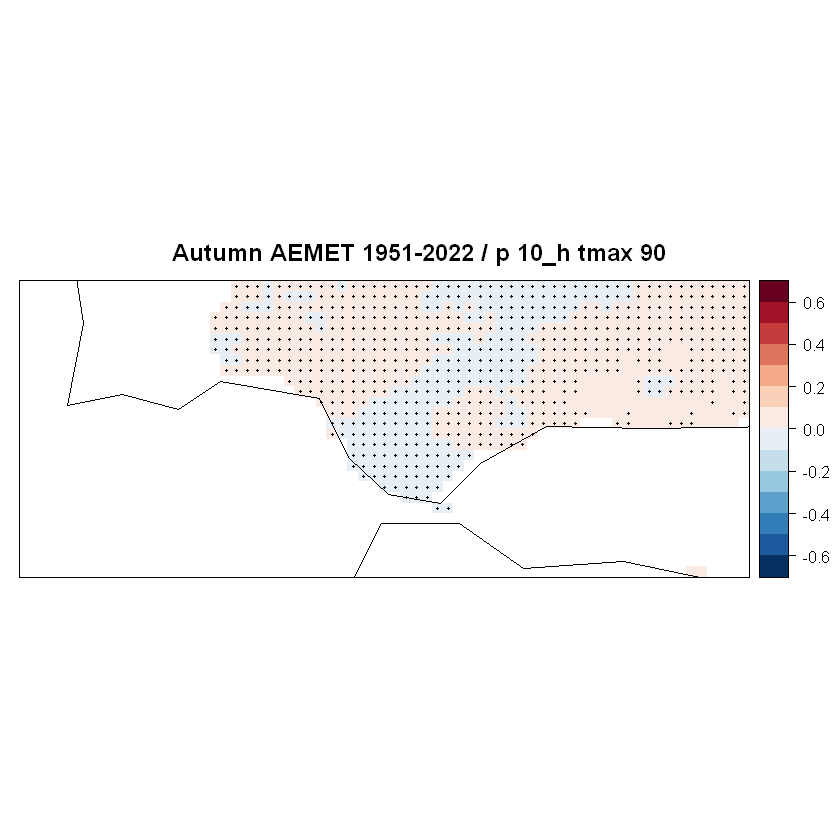

In [25]:
trend.autumn <- valueIndex(autumn, index.code = "Trend", return.NApercentage = FALSE)# La pendiente
sig.autumn <- valueIndex(autumn, index.code = "TrendSig", return.NApercentage = FALSE) # La significancia (1 o 0)
# Si significancia es 0 entonces la pendiente no es significativa = NA
clim.autumn = climatology(sig.autumn)
points.autumn <- visualizeR::map.stippling(clim.autumn, thereshold = 0.05, condition = "LT", pch = 19, cex = 0.25, col = "black")
# Representación
spatialPlot(trend.autumn, backdrop.theme = "coastline", color.theme = "RdBu", at = seq(-0.7, 0.7, by = 0.1), set.max = 0.7, set.min = -0.7, rev.colors = TRUE, main = "Autumn AEMET 1951-2022 / p 10_h tmax 90", sp.layout = list(points.autumn))

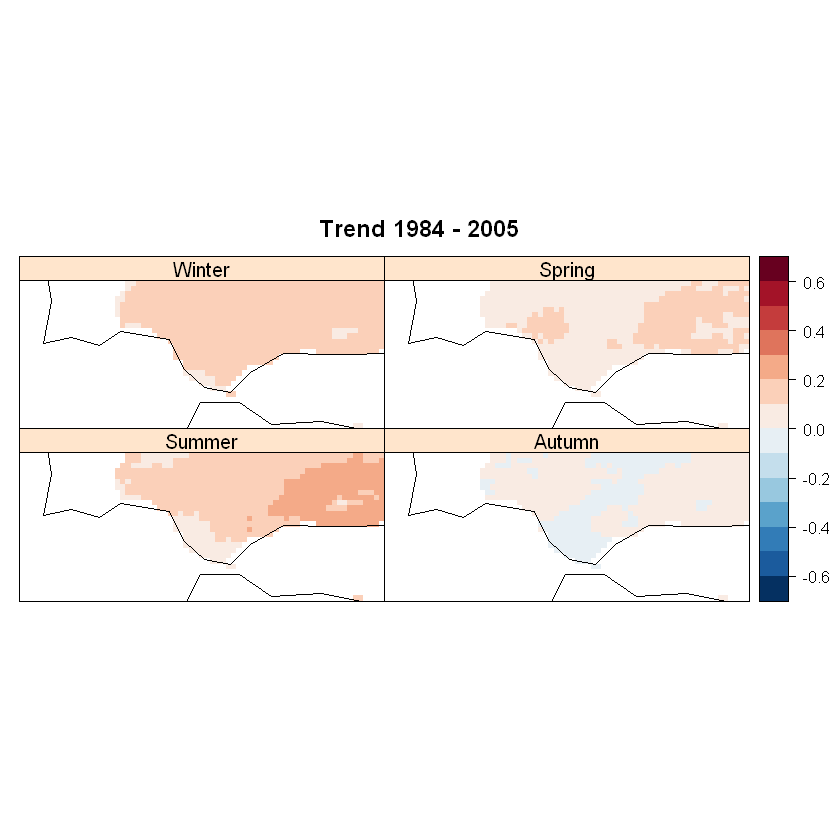

In [26]:
trends <- bindGrid(trend.winter, trend.spring, trend.summer, trend.autumn, dimension = "member", skip.temporal.check = TRUE)
# points <- bindGrid(points.winter, points.spring, points.summer, points.autumn, dimension = "member", skip.temporal.check = TRUE)
spatialPlot(trends, backdrop.theme = "coastline", names.attr = c("Winter", "Spring", "Summer", "Autumn"), main = "Trend 1984 - 2005", as.table = TRUE, color.theme = "RdBu", at = seq(-0.7, 0.7, by = 0.1), set.max = 0.7, set.min = -0.7, rev.colors = TRUE)